In [3]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl
import scipy.stats as spstats

In [14]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.gradients as grd

In [60]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
traceid='traces001'

In [16]:
# Metadata
visual_areas=['V1', 'Lm', 'Li']
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


In [17]:
# Receptive Field settings
experiment='rfs'
response_type='dff'

meta['session_int'] = meta['session'].astype(int)

dsets = meta[(meta.experiment==experiment) & (meta.visual_area.isin(['V1', 'Lm']))
            & (meta['session_int']>=20190511)].copy()


## Select dataset and create output dirs

In [18]:
dk = '20190617_JC097_fov1'
va = 'V1'

## Select parameters

In [19]:
# RF settings
is_neuropil=True
do_spherical_correction=False
fit_thr=0.5

In [20]:
basedir = os.path.join(aggregate_dir, 'receptive-fields', 'neuropil')

target_sigma_um=20
desired_radius_um=20
smooth_spline_x=1
smooth_spline_y=1
create_new=False
redo_smooth=True
is_neuropil=True
ds_factor=1

In [21]:
#### Some plotting stuff
scatter_kws={'s':2}

# Do it

#### Select output dirs

In [37]:
session, animalid, fovn = hutils.split_datakey_str(dk)
fovdir = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovn))[0]
curr_dst_dir = os.path.join(fovdir, 'segmentation')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/segmentation


#### Load NEUROPIL BACKGROUND

In [36]:
retinorun = grd.get_best_retinorun(dk)
print(dk, retinorun)
AZMAP_NP, ELMAP_NP = grd.load_neuropil_background(dk, retinorun,
                                            map_type='final', protocol='BAR')
#gvectors_BAR0 = load_gradient_results(dk, retinorun, results='vectors', protocol='BAR')
#regr_BAR0 = load_gradient_results(dk, retinorun, results='projections', protocol='BAR')

20190617_JC097_fov1 retino_run1


#### Load (or calculate) segmentation results

In [42]:
seg_results, seg_params = seg.load_segmentation_results(dk, retinorun=retinorun)
segmented_areas = seg_results['areas']
region_props = seg_results['region_props']
print(segmented_areas.keys())

dict_keys(['V1', 2])


In [44]:
assert va in segmented_areas.keys(), \
    "Visual area <%s> not in region. Found: %s" % (va, str(segmented_areas.keys()))
curr_area_mask = segmented_areas[va]['mask'].copy()
# curr_area_id = 

#### Calculate gradient vectors

In [45]:
grad_az, grad_el = seg.calculate_gradients(curr_area_mask, AZMAP_NP, ELMAP_NP)
    

In [46]:
# grad_az = seg.image_gradient(AZMAP_NP)
# grad_el = seg.image_gradient(ELMAP_NP)
GVECTORS = {'az': grad_az['vhat'], 'el': grad_el['vhat']}

In [47]:
%matplotlib notebook

<IPython.core.display.Javascript object>


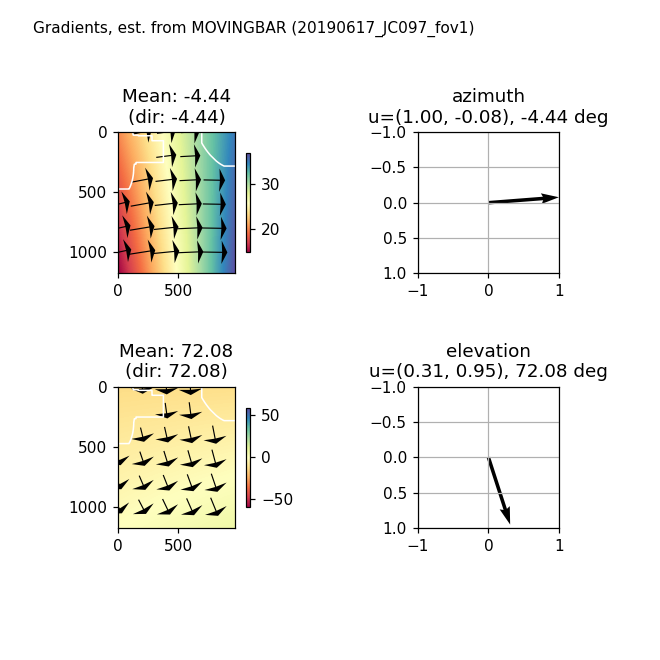

/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/segmentation


In [58]:
#### Plot gradients
spacing =200
scale = 0.0001 #0.0001
width = 0.01 #1 #0.01
headwidth=20
contour_lc='w'
contour_lw=1
cmap ='Spectral'
fig = seg.plot_gradients_in_area(curr_area_mask, AZMAP_NP, ELMAP_NP, 
                             grad_az, grad_el, cmap_phase=cmap,
                             contour_lc=contour_lc, contour_lw=contour_lw, 
                             spacing=spacing, 
                             scale=scale, width=width, headwidth=headwidth)
# fig = grd.plot_gradients(AZMAP_NP, ELMAP_NP, grad_az, grad_el,
#                   spacing=spacing, scale=scale, width=width, headwidth=headwidth)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.8, top=0.8)
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

pl.savefig(os.path.join(curr_dst_dir, 'np_gradients.svg'))
print(curr_dst_dir)

#### Load Neuropil data points

In [75]:
mag_thr=0.001
delay_map_thr=1.0
ds_factor=2

# Load FFT results
mags_soma, phases_soma, mags_np, phases_np, dims = grd.load_movingbar_results(dk, 
                                                                          retinorun)
# Get maps:  abs_vmin, abs_vmax = (-np.pi, np.pi)
mvb_np = retutils.get_final_maps(mags_np, phases_np, 
                    trials_by_cond=None,
                    mag_thr=mag_thr, dims=dims,
                    ds_factor=ds_factor, use_pixels=False)
# Add pos info to NP masks
mvb_np['cell'] = mvb_np.index.tolist()
mvb_np = hutils.add_meta_to_df(mvb_np, {'datakey': dk, 'visual_area': va,
                                        'experiment': experiment})
mvb_np = aggr.add_roi_positions(mvb_np)
# Adjust to LIN coords and filter bad masks
retinodf_np = grd.adjust_retinodf(mvb_np.dropna(), mag_thr=mag_thr)

DATA ID: 20190617_JC097_fov1_retino_run1_analysis002
Original dims: [512, 512]
Data were downsampled by 2.
256 256
Adding ROI position info...


<IPython.core.display.Javascript object>


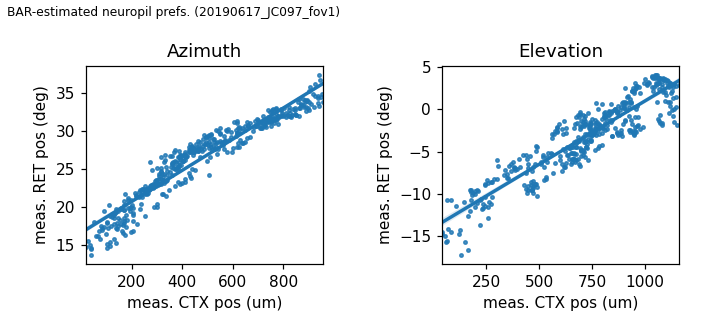

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/segmentation measured_ctx_vs_ret_BAR


In [79]:
#### Plot MEASURED ctx on ret pos
fig = grd.scatter_ctx_vs_retino_by_cond(retinodf_np, 
                             az_x='ml_pos', az_y='x0', 
                             el_x='ap_pos', el_y='y0',
                             xlabel='meas. CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'BAR-estimated neuropil prefs. (%s)' % dk, fontsize=8)
figname = 'measured_ctx_vs_ret_BAR'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Use NEUROPIL to estimate linear model

In [ ]:
# gvectors_=gvectors_BAR.copy() if USE_BAR else gvectors_TILE.copy()
# u1 = (gvectors_['az'])
# u2 = (gvectors_['el'])

<IPython.core.display.Javascript object>


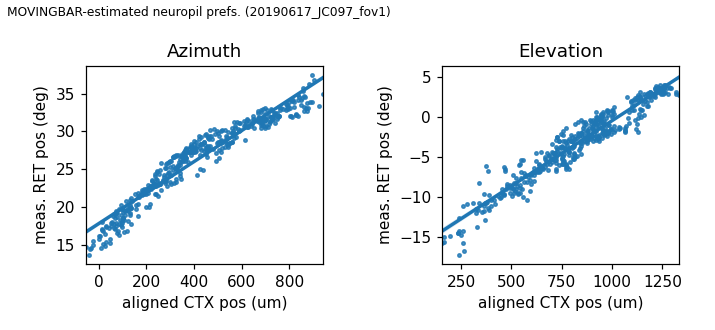

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/segmentation aligned_ctx_vs_measured_ret_BAR


In [84]:
# 1. Align FOV to gradient vector direction ***FIX THIS TO REPLACE W TRANSMAT
aligned_, M = grd.align_cortex_to_gradient(retinodf_np, GVECTORS,
                                  xlabel='ml_pos', ylabel='ap_pos')
aligned_np = pd.concat([retinodf_np, aligned_], axis=1).dropna()
# PLOT POST-alignment (should be better)
fig = grd.scatter_ctx_vs_retino_by_cond(aligned_np, 
                             az_x='ml_proj', az_y='x0', 
                             el_x='ap_proj', el_y='y0',
                             xlabel='aligned CTX pos (um)', 
                             ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'MOVINGBAR-estimated neuropil prefs. (%s)' % dk, fontsize=8)
figname = 'aligned_ctx_vs_measured_ret_BAR'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [90]:
# 2. Fit model
REGR_NP = grd.regress_cortex_and_retino_pos(aligned_np, xvar='proj', model='ridge')
REGR_NP

regr_np_meas = grd.regress_cortex_and_retino_pos(aligned_np, xvar='pos', model='ridge')


Measured ctx to y0: r=0.921 (p=0.000)
Aligned ctx to y0: r=0.962 (p=0.000)


<IPython.core.display.Javascript object>


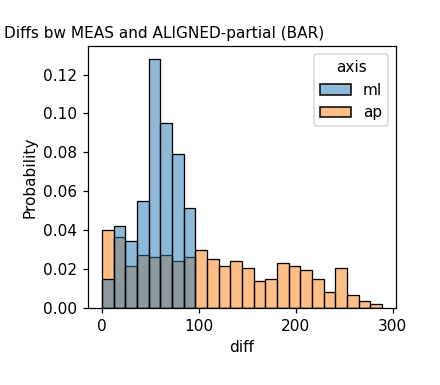

Text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (BAR)')

In [86]:
r0, p0 = spstats.pearsonr(aligned_np['y0'].values, aligned_np['ap_pos'].values)
r1, p1 = spstats.pearsonr(aligned_np['y0'].values, aligned_np['ap_proj'].values)
print('Measured ctx to y0: r=%.3f (p=%.3f)' % (r0, p0))
print('Aligned ctx to y0: r=%.3f (p=%.3f)' % (r1, p1))

diffs_ml = aligned_np['ml_pos'].round(2)-aligned_np['ml_proj'].round(2)
diffs_ap = aligned_np['ap_pos'].round(2)-aligned_np['ap_proj'].round(2)
diffs_true_proj = pd.DataFrame({'ml': diffs_ml.abs(), 'ap': diffs_ap.abs()})
diffs_ = diffs_true_proj.stack().reset_index()\
            .rename(columns={'level_1': 'axis', 0: 'diff'})

fig, ax = pl.subplots(figsize=(4,3.5))
sns.histplot(diffs_, x='diff', hue='axis', ax=ax, stat='probability', 
             common_norm=True, common_bins=True)
pl.subplots_adjust(left=0.2, bottom=0.2)
fig.text(0.01, 0.9, 'Diffs bw MEAS and ALIGNED-partial (BAR)')

MEASURED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.91768  | 1.52334 | 5.28461e-238 |    0.957956 |     0.0206098 |     16.5794 | az     |
|  1 | 0.848176 | 1.74746 | 3.62803e-180 |    0.920965 |     0.0148858 |    -13.9465 | el     |
ALIGNED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.929055 | 1.41418 | 4.72252e-252 |    0.963875 |     0.0204904 |     17.7941 | az     |
|  1 | 0.925344 | 1.22538 | 3.09813e-247 |    0.961948 |     0.0162791 |    -16.7408 | el     |


<IPython.core.display.Javascript object>


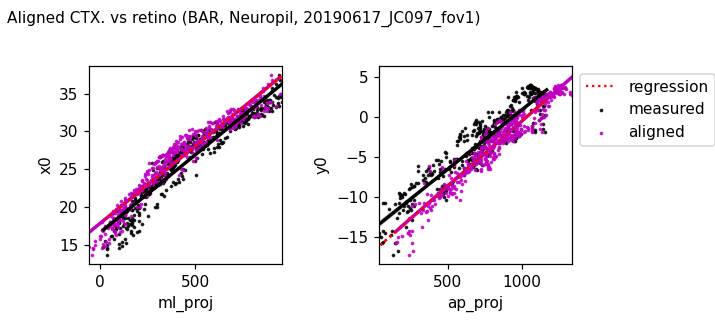

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

Text(0.01, 0.93, 'Aligned CTX. vs retino (BAR, Neuropil, 20190617_JC097_fov1)')

In [91]:
# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

fig, axn = pl.subplots(1,2, figsize=(6.5,3))
for ax, cond in zip(axn, ['az', 'el']):
    ctx_ = 'ml' if cond=='az' else 'ap'
    ret_ = 'x' if cond=='az' else 'y'
    sns.regplot('%s_pos' % ctx_, '%s0' % ret_, data=aligned_np, 
                ax=ax, color='k', scatter_kws={'s':2}, label='measured')
    sns.regplot('%s_proj' % ctx_, '%s0' % ret_, data=aligned_np, 
                ax=ax, color='m', scatter_kws={'s':2}, label='aligned')
    # show linear fit
    (slope, intercept), = REGR_NP[REGR_NP.cond==cond][['coefficient', 'intercept']].values
    xvs = aligned_np['%s_pos' % ctx_].values
    yvs = xvs*slope + intercept
    ax.plot(xvs, yvs, 'r:', label='regression')
pl.subplots_adjust(bottom=0.2, wspace=0.5, right=0.8, top=0.8)
pl.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.text(0.01, 0.93, 'Aligned CTX. vs retino (BAR, Neuropil, %s)' % dk)

#### Load soma

In [120]:
importlib.reload(grd)
%matplotlib notebook

In [122]:
df_soma = grd.load_soma_estimates(dk, protocol='TILES', 
                              experiment=experiment, retinorun=retinorun)
df_soma['cell'] = df_soma.index.tolist()
df_soma = hutils.add_meta_to_df(df_soma, {'datakey': dk, 'visual_area': va,
                                                'experiment': experiment})
df_soma = aggr.add_roi_positions(df_soma)
df_soma = df_soma.reset_index(drop=True)
print(df_soma.shape)

Adding ROI position info...
(89, 21)


<IPython.core.display.Javascript object>


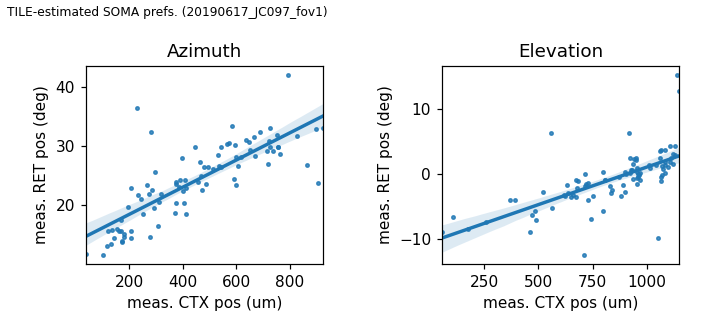

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/segmentation tile_measured_ctx_vs_ret_SOMA


In [124]:
#### PLOT MEASURED soma pos. vs ret pos
fig = grd.scatter_ctx_vs_retino_by_cond(df_soma, 
                                 az_x='ml_pos', az_y='x0', 
                                 el_x='ap_pos', el_y='y0',
                                 xlabel='meas. CTX pos (um)', 
                                 ylabel='meas. RET pos (deg)')
fig.text(0.01, 0.95, 'TILE-estimated SOMA prefs. (%s)' % dk, fontsize=8)
figname = 'tile_measured_ctx_vs_ret_SOMA'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Align soma coords to gradient

In [135]:
aligned_, M = grd.align_cortex_to_gradient(df_soma, GVECTORS,
                                  xlabel='ml_pos', ylabel='ap_pos')
aligned_soma = pd.concat([df_soma, aligned_], axis=1).dropna().reset_index(drop=True)
aligned_soma.tail()

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,datakey,...,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,predicted_ml_proj,predicted_ap_proj,predicted_ml_pos,predicted_ap_pos,ml_proj,ap_proj
84,15.713943,-3.314930,14.138214,16.704573,2.029929,-0.001249,0.069898,0.556762,424,20190617_JC097_fov1,...,852.865753,448,119.934247,882.623875,-101.516575,824.734405,-33.692832,877.685407,51.267558,876.705011
85,22.627207,-3.298668,24.012623,18.285052,0.229893,-0.001372,0.054277,0.524961,430,20190617_JC097_fov1,...,689.145988,362,283.654012,751.267319,235.874144,825.733308,296.505320,771.950819,224.662092,802.098925
86,15.822762,-1.432027,26.734560,18.901863,6.256460,-0.001323,0.063572,0.569007,432,20190617_JC097_fov1,...,835.732290,439,137.067710,956.367906,-96.205823,940.398564,-19.291530,994.590212,62.642525,952.143172
87,14.009833,-0.619097,19.311825,16.293702,5.001537,-0.002306,0.073124,0.554122,434,20190617_JC097_fov1,...,801.465362,421,171.334638,954.063405,-184.682942,990.335718,-101.887428,1073.784863,96.985028,960.494568
88,29.391281,2.538910,16.958953,20.467211,5.171178,-0.001720,0.050739,0.596734,436,20190617_JC097_fov1,...,323.632094,170,649.167906,949.454403,565.983906,1184.327795,648.038338,1035.146764,573.741888,1103.140632


In [136]:
regr_soma_meas = grd.regress_cortex_and_retino_pos(aligned_soma, 
                                                   xvar='pos', model='ridge')
regr_soma_proj = grd.regress_cortex_and_retino_pos(aligned_soma, 
                                                    xvar='proj', model='ridge')
print("MEASURED:")
print(regr_soma_meas.to_markdown())
print("ALIGNED:")
print(regr_soma_proj.to_markdown())

MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.647606 | 3.82333 | 2.08172e-21 |    0.804739 |     0.0230081 |     13.8583 | az     |
|  1 | 0.459531 | 3.0912  | 2.94944e-13 |    0.677887 |     0.0115506 |    -10.4449 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.64863  | 3.81777 | 1.83268e-21 |    0.805376 |     0.0225344 |     15.5606 | az     |
|  1 | 0.458474 | 3.09422 | 3.21448e-13 |    0.677107 |     0.0125251 |    -12.4757 | el     |


#### Predict SOMA pos from retino preference

In [137]:
p_x = grd.predict_cortex_position(REGR_NP, cond='az', 
                          points=df_soma['x0'].values)
p_y = grd.predict_cortex_position(REGR_NP, cond='el', 
                          points=df_soma['y0'].values)
df_soma['predicted_ml_proj'] = p_x
df_soma['predicted_ap_proj'] = p_y

#### Calculate inverse for visualizing on FOV

In [138]:
pred_INV = [np.linalg.inv(M).dot(np.array([x, y])) for (x, y) \
               in df_soma[['predicted_ml_proj', 'predicted_ap_proj']].values]
pred_inv_df = pd.DataFrame(pred_INV, columns=['pred_inv_x', 'pred_inv_y'], 
                      index=df_soma.index)

df_soma['predicted_ml_pos'] = pred_inv_df['pred_inv_x']
df_soma['predicted_ap_pos'] = pred_inv_df['pred_inv_y']

# Visualization

In [139]:
zimg, masks, ctrs = roiutils.get_masks_and_centroids(dk, traceid=traceid)
pixel_size = hutils.get_pixel_size()
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)


<IPython.core.display.Javascript object>


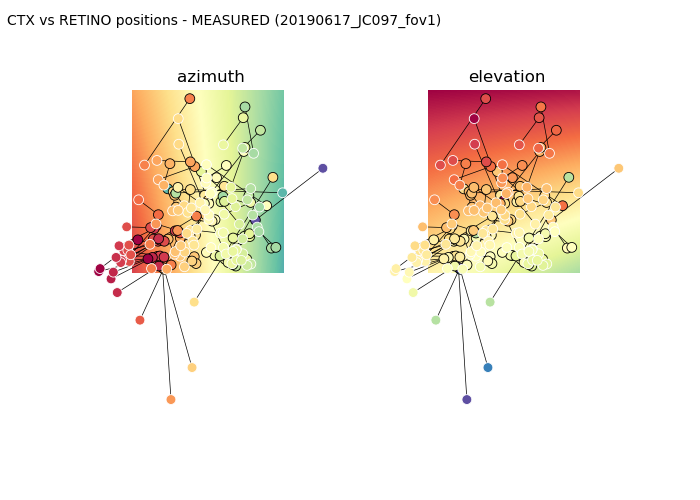

Text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (20190617_JC097_fov1)')

In [140]:
cmap='Spectral'
plot_true=True
plot_predicted=True
plot_lines=True

markersize=50
lw=0.6
alpha=1

df_ = df_soma.copy().reset_index(drop=True)

# Make sure we are in bounds of FOV
max_ypos, max_xpos = AZMAP_NP.shape
incl_plotdf = df_[(df_['predicted_ml_pos']>=0) & (df_['predicted_ml_pos']<=max_xpos)
           & (df_['predicted_ap_proj']>=0) & (df_['predicted_ap_proj']<=max_ypos)].copy()
excl_ixs = [i for i in df_.index.tolist() if i not in incl_plotdf.index]
#plotdf = df_.loc[excl_ixs].copy()
#plotdf = incl_plotdf.iloc[0::].copy()
plotdf=df_.copy()


fig, axn = pl.subplots(1, 2, figsize=(7,5))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_NP.copy() if cond=='azimuth' else ELMAP_NP.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='k', zorder=1000) 
    if plot_predicted:
        # Plot soma
        sns.scatterplot(x='predicted_ml_pos', y='predicted_ap_pos', 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor='w', zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[['predicted_ml_pos', 'predicted_ap_pos']].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
    
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)